In [ ]:
import bs4 as bs
import urllib.request

In [ ]:
source_lst1 = ['http://www.wuhanrc.org.cn/info/1003/2687.htm',
             'http://www.wuhanrc.org.cn/info/1003/2696.htm']
source_lst2 =['http://www.wuhanrc.org.cn/info/1003/2700.htm',
             'http://www.wuhanrc.org.cn/info/1003/2703.htm']
source_lst3 = ['http://www.wuhanrc.org.cn/info/1003/2704.htm',
             'http://www.wuhanrc.org.cn/info/1003/2729.htm']
source_lst4 = ['http://www.wuhanrc.org.cn/info/1003/2737.htm',
             'http://www.wuhanrc.org.cn/info/1003/2748.htm']
source_lst5 =['http://www.wuhanrc.org.cn/info/1003/2752.htm',
             'http://www.wuhanrc.org.cn/info/1003/2760.htm']
source_lst6 =['http://www.wuhanrc.org.cn/info/1003/2764.htm']

In [ ]:
source = urllib.request.urlopen('http://www.wuhanrc.org.cn/info/1003/2760.htm').read()
soup = bs.BeautifulSoup(source,'html.parser')
tbl_row = soup.table.find_all('tr')
for tr in tbl_row[1:]:
    td = tr.find_all('td')
    row = [i.text for i in td]
    s_lst.append(row)
print("read one page")

In [ ]:
len(s_lst)

In [ ]:
for i,row in enumerate(s_lst):
    if len(row) == 4:
        s_lst[i]=[s_lst[i-1][0]] + row

In [ ]:
import pandas as pd

In [ ]:
donation = pd.DataFrame(data = s_lst, columns = ['接收单位', '品名', '规格', '计量单位', '数量'])

In [ ]:
donation.to_csv('WHRC_donation_0204to0213.csv')

In [2]:
import pandas as pd
donation=pd.read_csv('WHRC_donation_0204to0213.csv')

In [3]:
protect_suit = donation[(donation['品名'].str.contains('防护服')) & (donation['品名'] != '非医用防护服')\
         &(donation['品名'] != '居家隔离防护服包')].copy()

In [4]:
protect_suit['Tao'] = protect_suit['规格'].str.extract('(\d+套)', expand=True)[0].str.extract('(\d+)', expand=True)
protect_suit['Jian'] = protect_suit['规格'].str.extract('(\d+件)', expand=True)[0].str.extract('(\d+)', expand=True)


In [5]:
import numpy as np
protect_suit['特殊单位'] = np.where(protect_suit['Tao'].notnull() == True, protect_suit['Tao'], protect_suit['Jian'])


In [6]:
protect_suit['特殊单位'] = np.where(protect_suit['规格'] == '600PLNS \xa0 2XL号', 100, protect_suit['特殊单位'])
protect_suit['特殊单位'] = np.where(protect_suit['规格'] == '600PLNS \xa0 LG号', 100, protect_suit['特殊单位'])

In [7]:
protect_suit['特殊单位'] = protect_suit['特殊单位'].fillna(0).astype('int64')
protect_suit['数量'] = protect_suit['数量'].astype('int64')

In [8]:
protect_suit['接收单位类别'] = np.where(protect_suit['接收单位'].str.contains('院'), '医院', '行政')
protect_suit['接收单位类别'] = np.where(protect_suit['接收单位'].str.contains('方舱'), '医院', protect_suit['接收单位类别'])

In [9]:
protect_suit['处理后数量'] = np.where(protect_suit['特殊单位'] == 0, protect_suit['数量'], \
                                 protect_suit['特殊单位']*protect_suit['数量'])

protect_suit['处理后数量'] = np.where((protect_suit['接收单位类别'] == '行政')&\
             (protect_suit['品名'] == '防护服Plus600型')&(protect_suit['计量单位'] == '套'), \
                             protect_suit['处理后数量']/protect_suit['特殊单位'],\
                                 protect_suit['处理后数量'])

protect_suit['处理后数量'] = np.where((protect_suit['品名']=='防护服')&(protect_suit['处理后数量']>10000),\
                                 protect_suit['处理后数量']/protect_suit['特殊单位'],\
                                 protect_suit['处理后数量'])
protect_suit['处理后数量'] = np.where((protect_suit['品名']=='医用防护服')&(protect_suit['处理后数量']>10000),\
                                 protect_suit['处理后数量']/protect_suit['特殊单位'],\
                                 protect_suit['处理后数量'])

In [10]:
protect_suit.head()

,Unnamed: 0,接收单位,品名,规格,计量单位,数量,Tao,Jian,特殊单位,接收单位类别,处理后数量
514,514,武汉市蔡甸区,防护服,20套/箱,套,3,20,NaN,20,行政,60.0
515,515,武汉市蔡甸区,防护服 L号,***,套,130,NaN,NaN,0,行政,130.0
516,516,武汉市蔡甸区,防护服 M号,***,套,130,NaN,NaN,0,行政,130.0
517,517,武汉市蔡甸区,防护服 S号,***,套,130,NaN,NaN,0,行政,130.0
518,518,武汉市蔡甸区,防护服 XL号,***,套,7,NaN,NaN,0,行政,7.0


In [11]:
plot1 = protect_suit.groupby('接收单位类别').sum()['处理后数量'].reset_index()

In [12]:
plot2_pre = protect_suit.groupby(['接收单位类别','品名']).sum().reset_index()
plot2 = plot2_pre[plot2_pre['接收单位类别'] == '行政']

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style


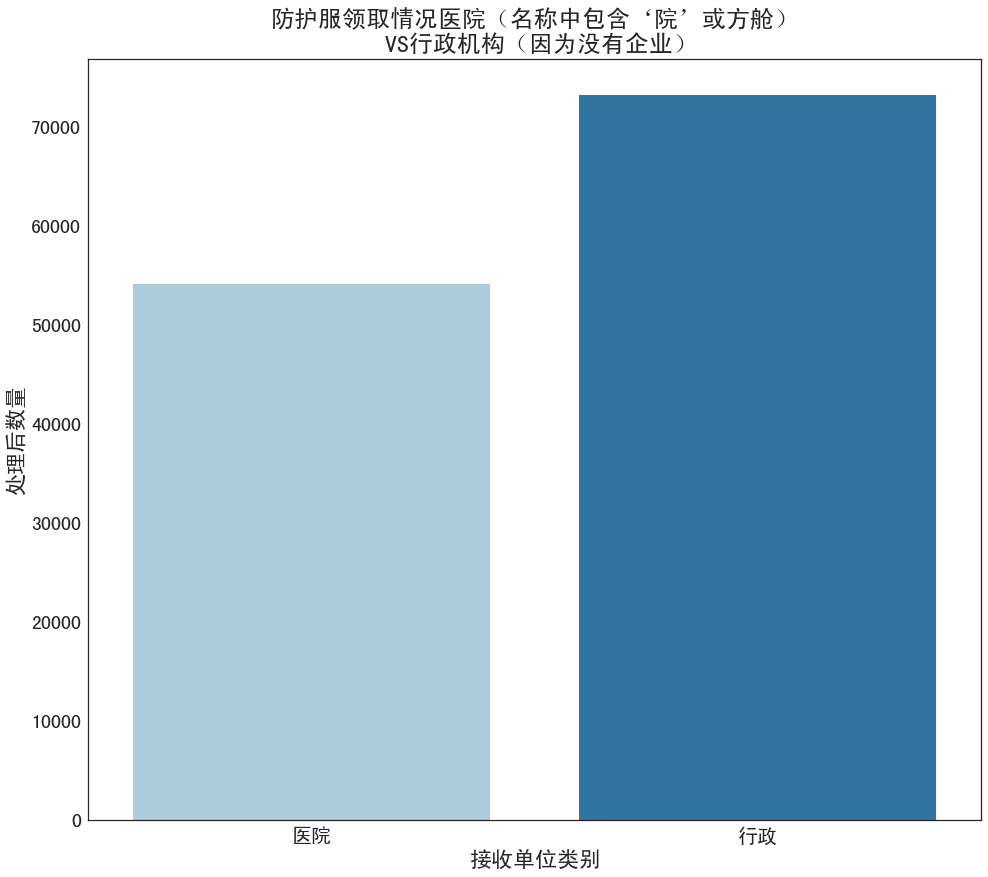

In [44]:
plt.figure(figsize=(16, 14))
style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['SimHei']
g = sns.barplot(x="接收单位类别", y="处理后数量",data=plot1, palette=("Paired"))
g.set_title("防护服领取情况医院（名称中包含‘院’或方舱）\n VS行政机构（因为没有企业）")
plt.show()

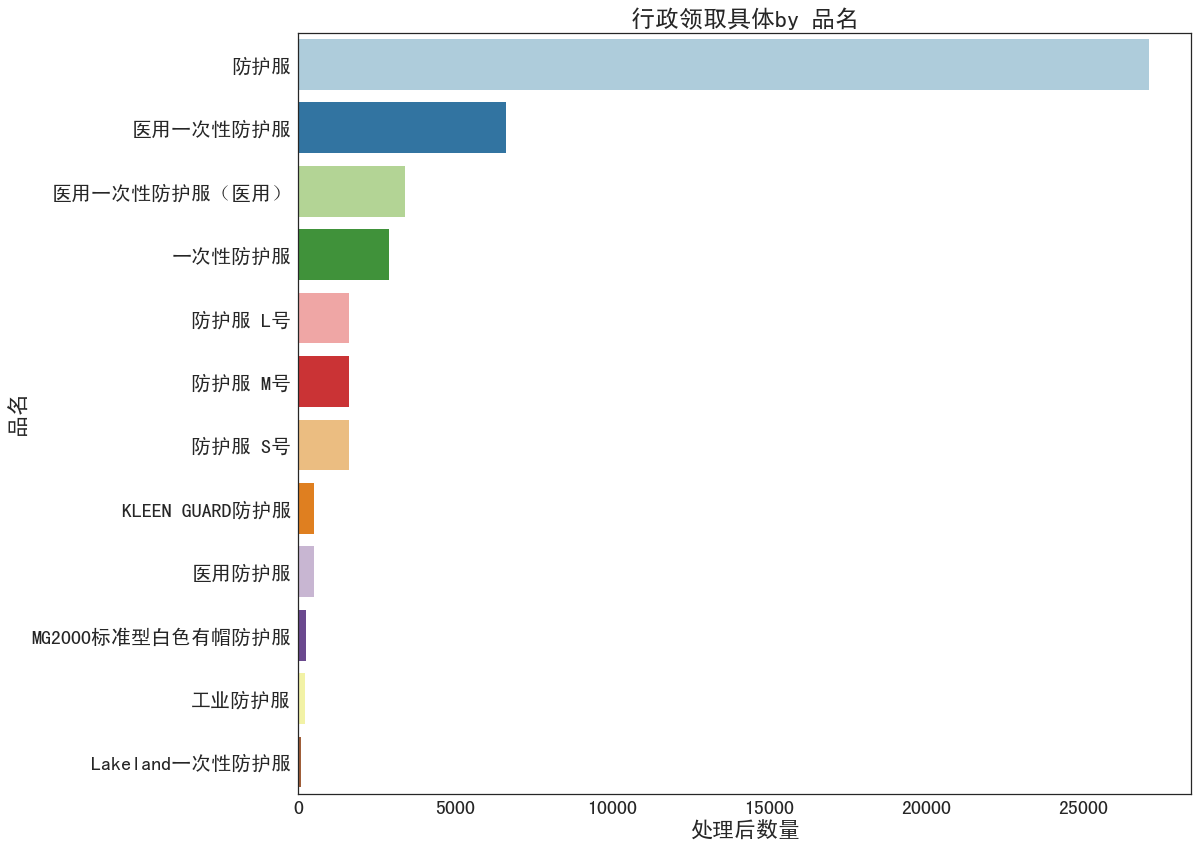

In [45]:
plt.figure(figsize=(16, 14))
style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['SimHei']
g2 = sns.barplot(y="品名", x="处理后数量",\
                 data=plot2.head(12).sort_values(by = '处理后数量',ascending=False), \
                 palette=("Paired"))
g2.set_title("行政领取具体by 品名")
plt.show()

In [19]:
protect_suit[(protect_suit['接收单位类别']=='行政') & (protect_suit['品名']=='防护服')\
             &(protect_suit['处理后数量']>2000)]

,Unnamed: 0,接收单位,品名,规格,计量单位,数量,Tao,Jian,特殊单位,接收单位类别,处理后数量
2907,2907,江夏区卫生健康局,防护服,500型 XL,套,2100,NaN,NaN,0,行政,2100.0
3630,3630,武汉市卫生健康委员会,防护服,2XL,套,4375,NaN,NaN,0,行政,4375.0


In [20]:
plot3 = protect_suit.groupby('接收单位').sum().sort_values(by = '处理后数量',ascending=False).reset_index().head(10)

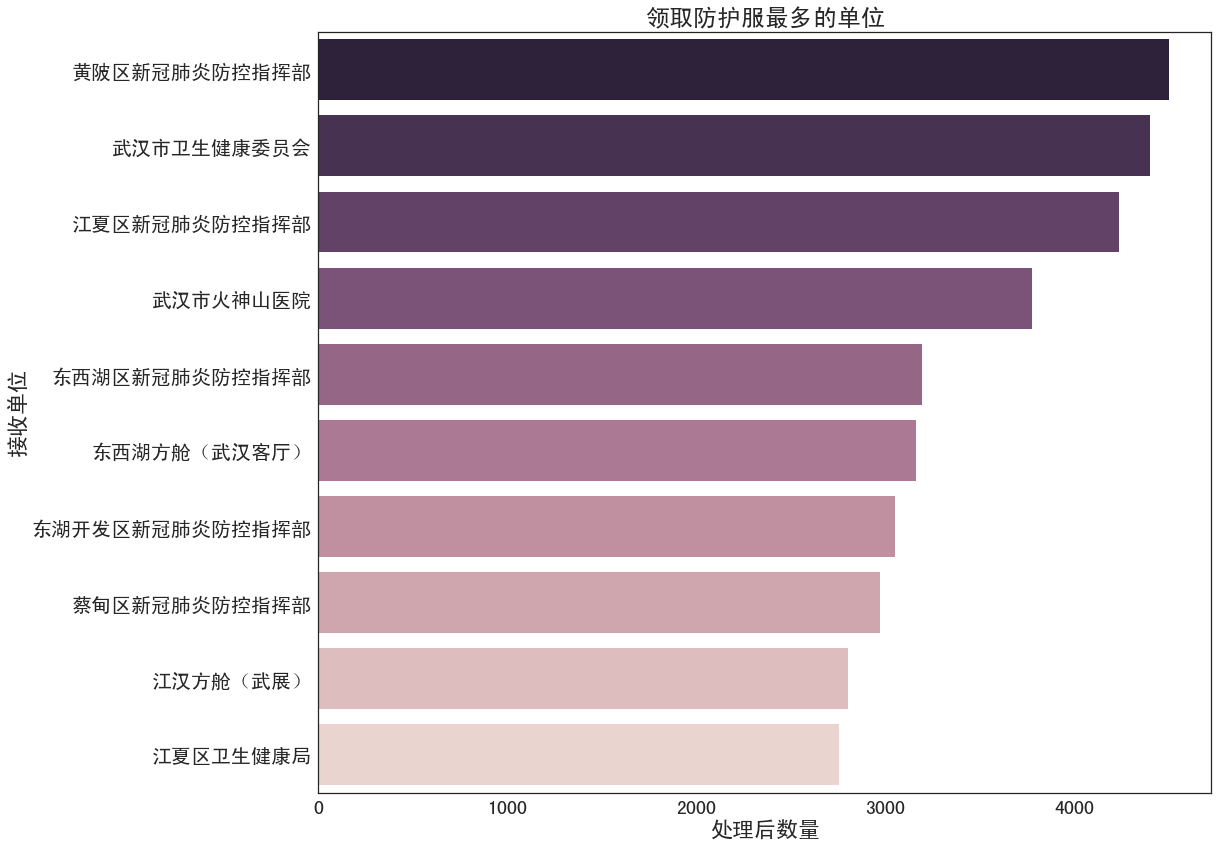

In [50]:
plt.figure(figsize=(16, 14))
style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['SimHei']
g3 = sns.barplot(y="接收单位", x="处理后数量",data=plot3, palette=(sns.cubehelix_palette(10, reverse=True)))
g3.set_title("领取防护服最多的单位")
plt.show()

In [ ]:
plt.clf()